In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import decode_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Model selection, preview and preprocessing

We choose to apply **transfer learning** for this image classification task. This way, we accelerate the train process, we use less data to fit a good model and we use the pretrained model as feature extraction module.

In [6]:
from torchvision.models import vgg19, VGG19_Weights

weights = VGG19_Weights.DEFAULT
model = vgg19(weights = weights)

The model is named **VGG19**. We choose this pretrained model, as it has been used already (a finetuned version of it) to classify xray lung images for covid based on this source:<br> https://www.nature.com/articles/s41598-024-61693-0#Sec1<BR><BR> As the article describes,<BR><BR>
"_VGG19 was one of the winners of the Image Net Large Scale Visual Recognition Challenge (ILSVRC) in 2014. The size of the input image to VGG19 is (224 × 224). VGG19 contains 16 convolution layers,<BR> 5 max-pooling layers and 3 fully connected layers. The convolution layers are with (3 × 3) filters' size, stride of 1 pixel and padding of 1 pixel. The max-pooling layers are with a size of 2 × 2 and a stride of 2. The rectification (ReLU) activation function is utilized for all hidden layers. Then, the first 2 fully connected layers with 4096 channels each are uitilized followed by the last layer of 1000 channels to represent the different 1000 classes of the ImageNet with soft-max activation function15._"<br><BR>
The above architecture can be illustrated to the image bellow:<br><br>
![Alt text](vgg19.png)<br> source: https://www.mdpi.com/2624-7402/4/4/56 <br><br>



We can observe the layers in pytorch by calling the model object:

In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Bellow we present a 3 by 10 plot, which illustrates the values of the first 10/64 filters of the first convolutional layer. The RGB components are distributed row-wise, where the i'th column representing the i'th filter

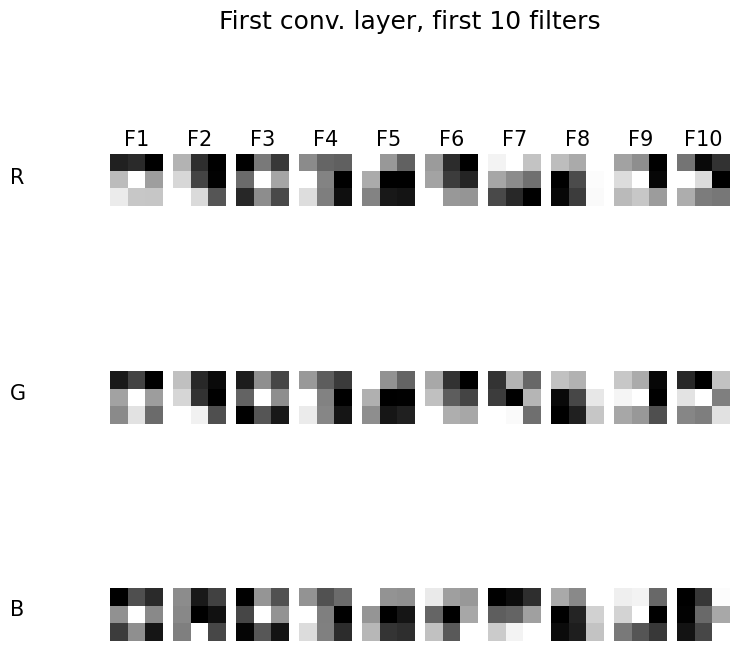

In [97]:
with torch.no_grad():
    # Get the first 10/64, 3 by 3 by 3 filters of the first layer
    first_layer_params = list(model.parameters())[0][:10]

    # Extract and plot the RGB layers of each filter
    fig, axes = plt.subplots(3, 10, figsize=(8, 8))
    plt.suptitle("First conv. layer, first 10 filters", fontsize = 18)
    for i in range (10):
        axes[0, i].set_title(f"F{i+1}", fontsize = 15)
        
        axes[0, i].imshow(first_layer_params[i][0], cmap = "gray")
        axes[1, i].imshow(first_layer_params[i][1], cmap = "gray")
        axes[2, i].imshow(first_layer_params[i][2], cmap = "gray")

        axes[0, i].axis("off")
        axes[1, i].axis("off")
        axes[2, i].axis("off")

    fig.text(0, 0.77, "R", fontsize=15, va='center')
    fig.text(0, 0.5, "G", fontsize=15, va='center')
    fig.text(0, 0.23, "B", fontsize=15, va='center')



The above filters, along with the rest 54 of the first convolutional layer, are applied to a **preprocessed** and **normalized** version of the input image.

In [3]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Lets test the VGG19 input preprocessing. We repeat the original grayscale image channel by 3 (RGB), because the preprocessing assumes RGB images.

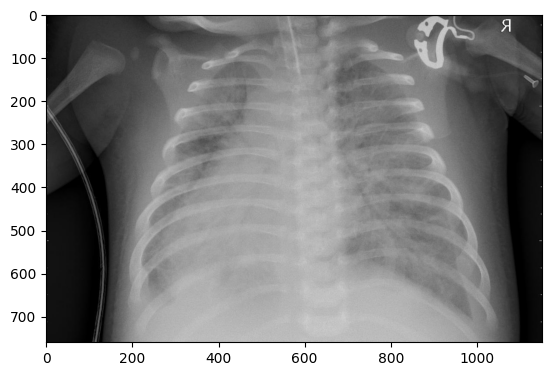

In [8]:
inf = decode_image("./xrays/COVID/2.jpeg").repeat(3,1,1) # Repeat 3 times the gray channel to convert to RGB
plt.imshow(inf.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1760426..1.733682].


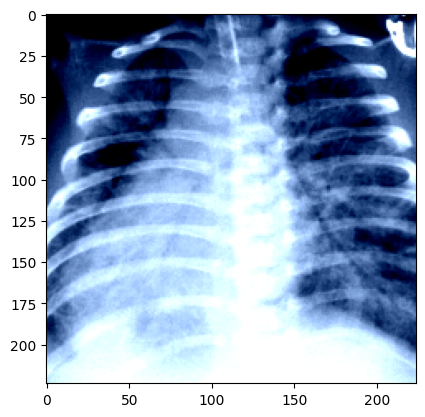

In [9]:
preprocess = weights.transforms()
inf_proc = preprocess(inf) # 3 224 224
plt.imshow(inf_proc.permute(1,2,0))

Lets see what our model currently predicts for the above preprocessed image:

In [ ]:
# Make a test prediction with the pretrained model
model.eval()
batch = inf_proc.unsqueeze(0)

prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

perfume: 12.1%


# Model classifier modification

VGG19 model has been trained to classify 1000 categories of objects. We want to be able to classify an image as Healthy (1) or Covid (0). We take a look at the classifier part (the final fully connected layers) and we modify the 1000 output nodes to simply 1. After adding a Sigmoid output activation, we can classify as Covid if output probability <= 0.5 and as Healthy otherwise.

In [13]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

We Freeze all the parameters (make them non trainable) and change the final layer from Linear(4096, 1000) to Linear(4096, 1). Therefore, our trainable parameters are going to be 4097 (4096 + 1 for bias)

In [14]:
# Freeze pretrained model's parameters
for param in model.parameters():
    param.requires_grad = False
    #print(param.shape)

In [ ]:
# Change last layer and extend model with new layers. These layers are trainable (requires_grad = True)

model.classifier[-1] = nn.Linear(4096, 1)
'''model.classifier.append(nn.ReLU(inplace=True))
model.classifier.append(nn.Dropout(p = 0.5, inplace=False))
model.classifier.append(nn.Linear(2048, 1024))
model.classifier.append(nn.ReLU(inplace=True))
model.classifier.append(nn.Dropout(p = 0.5, inplace=False))
model.classifier.append(nn.Linear(1024,  512))
model.classifier.append(nn.ReLU(inplace=True))
model.classifier.append(nn.Dropout(p = 0.5, inplace=False))
model.classifier.append(nn.Linear(512,  1))'''
model.classifier.append(nn.Sigmoid())


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1, bias=True)
  (7): Sigmoid()
)

# Dataset loading and model training

Load the train and validation dataset

In [10]:
# Load train image dataset and perform the vgg19 preprocess
train_dataset = ImageFolder(root="xrays", transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load test image dataset and perform the vgg19 preprocess
val_dataset = ImageFolder(root='validation', transform=preprocess)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Categories to labels
train_dataset.class_to_idx

{'COVID': 0, 'HEALTHY': 1}

We choose the BCE (Binary Cross Entropy) as a minimization loss function.
As an optimizer, we use Adam.

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

We train the model for 10 epochs and keep track of the train-validation errors and accuracies for each epoch. We store the best model weights among the epochs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training and validation loop
epochs = 10
train_epoch_errors = []
train_epoch_acc = []
validation_epoch_errors = []
validation_epoch_acc = []
best_val_loss = 1000
best_weights = model.state_dict()
#best_cm = np.zeros((2,2))

for epoch in range(epochs):
    # Train loop
    model.train()
    running_loss = 0
    running_acc = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # For accuracy, set output to 1 if >0.5 and 0 otherwise
        running_acc += accuracy_score(labels, outputs.round().to(dtype = torch.uint8))
    
    # Compute average loss and accuracy per batch
    epoch_error = round(running_loss/len(train_loader), 2)
    epoch_acc = round(running_acc/len(train_loader), 2)

    train_epoch_errors.append(epoch_error)
    train_epoch_acc.append(epoch_acc)
    print(f"Epoch {epoch+1}, Train average loss per batch: {epoch_error}", f"Avg acc: {epoch_acc}")

    # Validation loop
    with torch.no_grad():
        model.eval()
        running_loss_val = 0
        running_acc_val = 0
        #cm = np.zeros((2,2))
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()

            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_loss_val+=val_loss.item()
            # For accuracy, set output to 1 if >0.5 and 0 otherwise
            running_acc_val += accuracy_score(labels, outputs.round().to(dtype = torch.uint8))
            # Update confusion matrix
            #cm += confusion_matrix(labels, outputs.round().to(dtype = torch.uint8))        

        # Compute average loss and accuracy per batch
        epoch_error_val = round(running_loss_val/len(val_loader), 2)
        epoch_acc_vall = round(running_acc_val/len(val_loader), 2)

        # Store best model weights and confusion matrix
        if epoch_error_val < best_val_loss:
            best_weights = model.state_dict()
            best_val_loss = epoch_error_val
            #best_cm = cm
        
        validation_epoch_errors.append(epoch_error_val)
        validation_epoch_acc.append(epoch_acc_vall)
        print(f"Epoch {epoch+1}, Validation average loss per batch: {epoch_error_val}", f"Avg acc: {epoch_acc_vall}")

# Set the best weights and save the best model
model.load_state_dict(best_weights)
torch.save(model, "best_model.pth")

# Save train and validation epoch errors and accuracies
pd.DataFrame(data={"Epoch" : list(range(1, epochs+1)), f"Avg Train batch loss (size = {train_loader.batch_size})" : train_epoch_errors, "Avg acc" : train_epoch_acc}).to_csv("train_loss_acc.csv", index=False)
pd.DataFrame(data={"Epoch" : list(range(1, epochs+1)), f"Avg Val batch loss (size = {val_loader.batch_size})" : validation_epoch_errors, "Avg acc" : validation_epoch_acc}).to_csv("val_loss_acc.csv", index=False)

'''# Save best confusion matrix
pd.DataFrame(index=["True 0", "True 1"], data = best_cm, columns=["Predicted 0", "Predicted 1"]).to_csv("best_cm.csv")'''


# Train-Validation loss, Train-Validation accuracy and confusion matrix

We iterate through the validation batches one more, to store the best model's predicted labels and the actual labels. From these, we compute the confusion matrix

In [94]:
model = torch.load("best_model.pth")

C:\Users\nikos\AppData\Local\Temp\ipykernel_23332\3488002990.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model.pth")


In [ ]:
# Compute confusion matrix on validation set using the best model

y_true = []
y_pred = []
with torch.no_grad():
    for x, y in val_loader:
        y_true.extend(y.numpy())
        y_pred.extend(model(x).squeeze(1).round().to(torch.uint8).numpy())

best_cm = confusion_matrix(y_true, y_pred)

# Save best confusion matrix
pd.DataFrame(index=["True 0", "True 1"], data = best_cm, columns=["Predicted 0", "Predicted 1"]).to_csv("best_cm.csv")

In [11]:
# Check if confusion matrix is valid
best_cm = pd.read_csv("best_cm.csv")[["Predicted 0", "Predicted 1"]].to_numpy()
best_cm.sum() == len(val_loader.dataset)

True

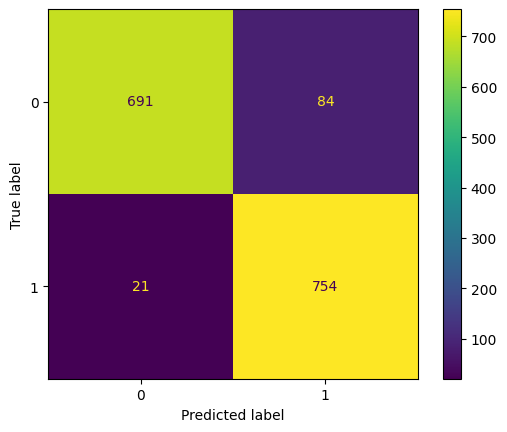

In [ ]:
# Plot the confusion matrix
ConfusionMatrixDisplay(best_cm).plot()

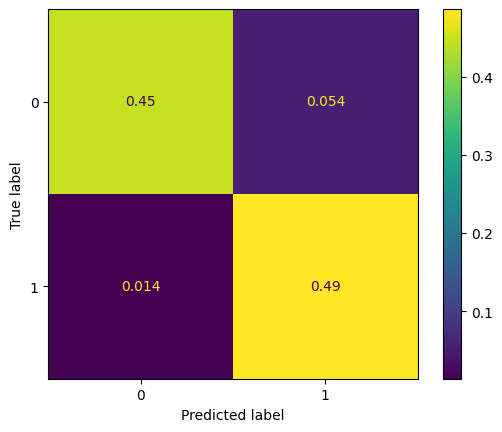

In [12]:
# Plot the confusion matrix (as percentages)
ConfusionMatrixDisplay(best_cm/best_cm.sum()).plot()

We make the loss and accuracy graphs to better interpret the learning history of the model

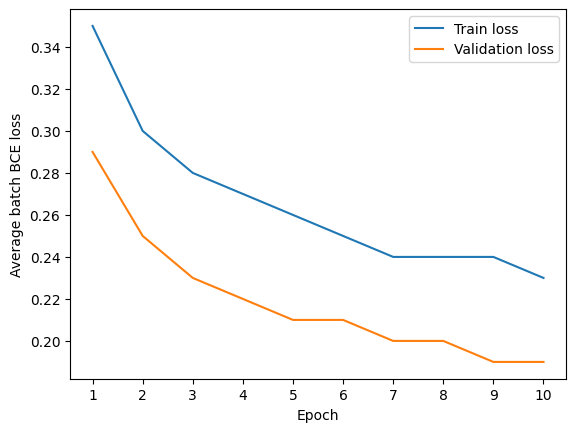

In [ ]:
# Plot train and validation loss
train_epoch_errors, validation_epoch_errors = pd.read_csv("train_loss_acc.csv")["Avg Train batch loss (size = 32)"], pd.read_csv("val_loss_acc.csv")["Avg Val batch loss (size = 32)"]

plt.plot(train_epoch_errors)
plt.plot(validation_epoch_errors)
plt.xlabel("Epoch")
plt.xticks(range(10), range(1, 11))
plt.ylabel("Average batch BCE loss")
plt.legend(["Train loss", "Validation loss"])

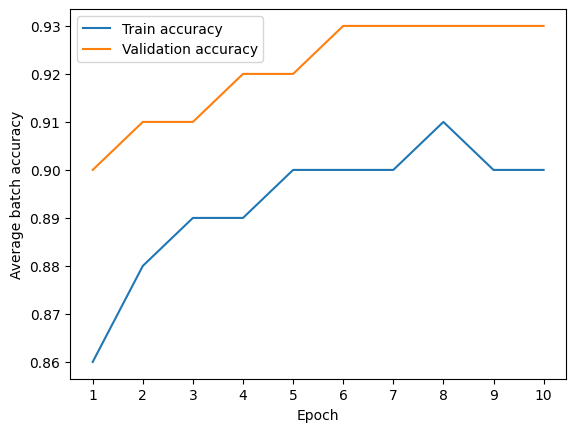

In [312]:
# Plot train and validation accuracy
train_epoch_acc, validation_epoch_acc = pd.read_csv("train_loss_acc.csv")["Avg acc"], pd.read_csv("val_loss_acc.csv")["Avg acc"]

plt.plot(train_epoch_acc)
plt.plot(validation_epoch_acc)
plt.xlabel("Epoch")
plt.xticks(range(10), range(1, 11))
plt.ylabel("Average batch accuracy")
plt.legend(["Train accuracy", "Validation accuracy"])

# Conclusions

After taking a look at the given dataset, one can notice that the proportions of HEALTHY and COVID classified images are quite different. Therefore, a data augmentation technique had to be applied, in order to balance the sample categories and avoid model bias. We concluded that if we add some flipped copies on the minor class, we can achieve balanced proportions, in the condition that the same technique had to be applied on the major class as well, to achieve better data homogenity.<p>

Transfer learning seemed an efficient solution to our problem, thanks to our modification of the pretrained VGG19 model, which has been trained initialy to classify 1000 objects. Our own modification consisted of a replacement of the final layer of size 1000 with a single node. The new 4097 occured weights, helped the model to learn how to transform the extracted features to one value, which corresponds to the probability of observing class 1 (HEALTHY) input. The final metrics on the validation set confirm that the model achieved a good performace to our image classification task: <p>

<li> Average validation set batch loss: <b>0.19</b> </li>
<li> Average validation set batch accuracy: <b>93%</b> </li>